# Abstract

In this notebook, I will focus on an approach that suggested by Victor Lo. He was suggesting using the dummy variable to decide whether a customer will be given a promo or not. By comparing the model results and substract them and then if the result is above certain threshold it will be flagged as prospectus customer, otherwise if customer below certain threshold it won't be targetted to customer promos. The Victor Lo presentation: [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation)

# Portfolio Exercise: Starbucks
<br>
<br>
<img src="http://www.pngmart.com/files/3/Starbucks-Logo-PNG-File.png" width="200" height="200">
<br>
<br>

## Background Information

The dataset that will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at **10 bucks** . Since it costs the company **0.15 bucks** to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

## Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 Dollar times the total number of purchasers that received the promotion minus 0.15 Dollar times the number of promotions sent out, minus 10 Dollar times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below we can find the training data provided.  Explore the data and different optimization strategies.

## How To Test Your Strategy?

When we feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

# The Analytical Steps.

## Import and variables

In [34]:
# load in packages
from itertools import combinations

from test_results import valid_results, test_results, score
from IPython.display import Image
from IPython.core.display import HTML 

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [9]:
# load in the data
train_data = pd.read_csv('./training.csv')
# train_data.head()
test_data = pd.read_csv('./Test.csv')
# test_data.head(7)

In [10]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [11]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [12]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

## EDA

## Training | Promotion and Purchase

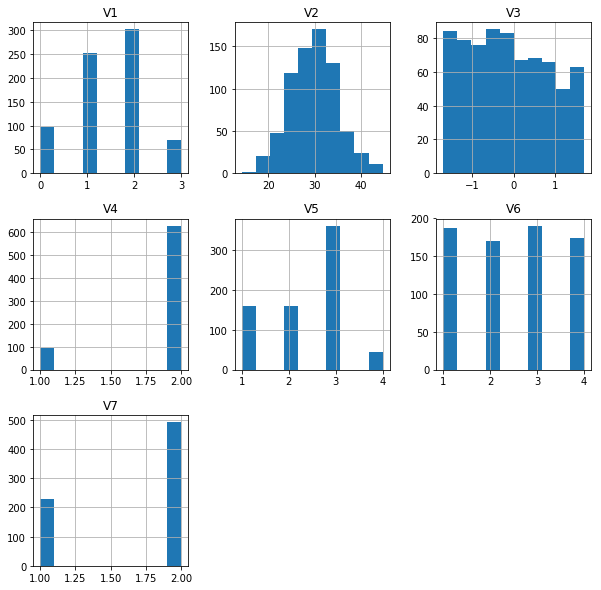

In [13]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

## Promotion and Purchase-not

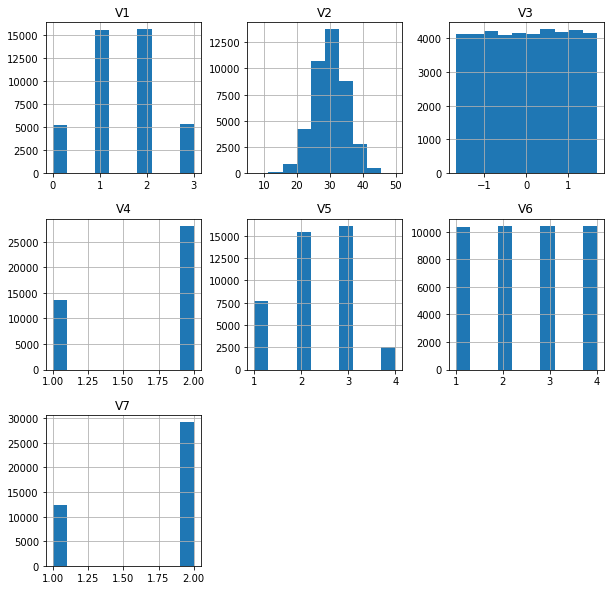

In [10]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

## Promotion-not and Purchase

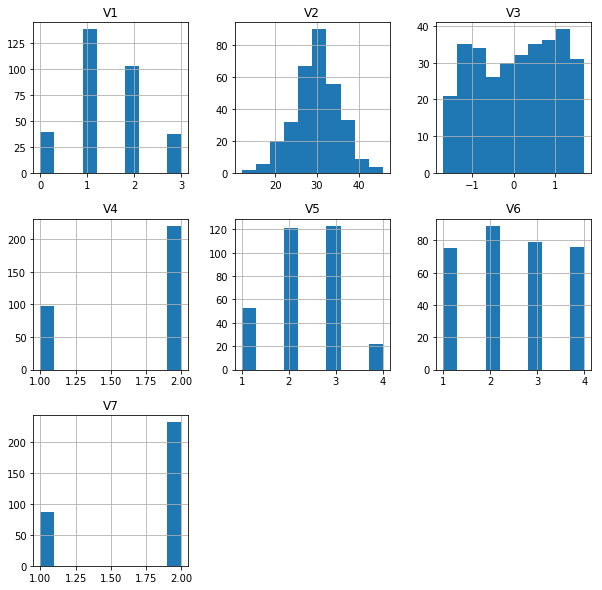

In [11]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

## Promotion-not and Purchase-not

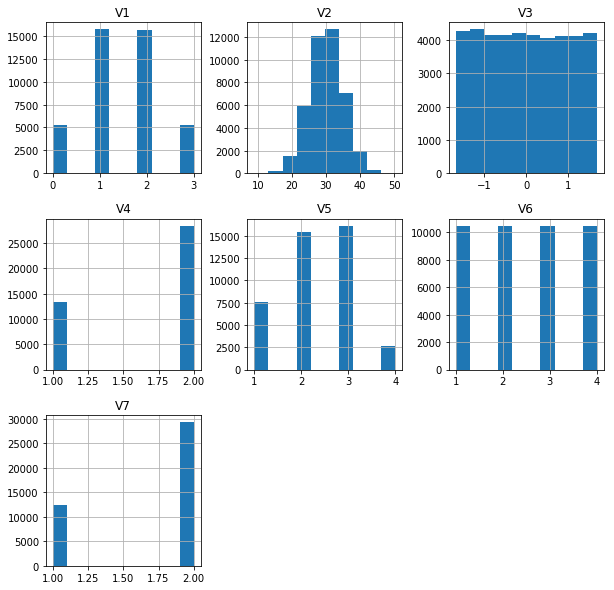

In [12]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

In [17]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [25]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

In [26]:
# Check sample size needed for control and treatment groups
NormalIndPower().solve_power(effect_size = proportion_effectsize(.0096, .015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

In [27]:
# calculate our current treatment group size
train_data[train_data['Promotion']=='Yes'].shape[0]

42364

In [28]:
# calculate our current control group size
train_data[train_data['Promotion']=='No'].shape[0]

42170

If we were to send everyone a promotion, our IRR is 0.96\% and NIR is -\\$1,132.20. This will be the baseline model. Hence, blindly sending everyone a promotion is going to lose the company a lot of money.

Our baseline IRR is 0.096\%. If our desired minimum IRR is 1.5\% (an 0.081\% absolute increase in IRR), and we want to detect this change with a type 1 error rate of 0.05 and a power of 0.80, we will need a sample size of approximately 5,090 in each group (both control and treatment). Since, we have more than 40,000 data points in each group, we have sufficient data

# An approach: Using Treatment Dummy Approach

In this approach, a single model is used to model the data. Unlike the approach used in the first model, this approach adds an additional indicator variable to track if an individual is in a treatment or control group during training. Any individuals who made purchases will be given a label of 1, irregradless of whether he or she is in the control or treatment group. 

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion):

$$Lift = P(purchase | I_{treat} = 1) - P(purchase |  I_{treat} = 0)$$

We can opt to send promotions to individuals with prostive lift values. Using this approach for this dataset, an irr of 1.42\% and an nlr of -\\$47.40 is obtained for the validation set. On the other hand, the irr and nlr values for the test set is 1.54\% and \\$42.60 respectively. Such a drastic difference between the validation and test nlrs is certainly surprising. The test results does seem to suggest that this is could be a relatively good approach as well. Alternative models, new feature generation and alternative upsampling methods could be tried to improve the results. In addition, you can also choose to send promotions only to individuals with lift values above a certain percentile.

This approach is a slight modification of the method proposed by Victor Lo in the previously mentioned presentation, which can be found [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation). The original method proposes a logistic regression model.

In [14]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [15]:
# encode Promotion as 0 or 1 indicator variable
train_data['treatment'] = np.where(train_data['Promotion'] == "Yes", 1, 0)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [16]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'treatment']

Y_train = train['purchase']
X_train = train[features]

Y_valid = valid['purchase']
X_valid = valid[features]

In [17]:
# up sample with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [36]:
eval_set = [(X_train, Y_train), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.695828	validation_1-auc:0.654634
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.699396	validation_1-auc:0.660875
[2]	validation_0-auc:0.70441	validation_1-auc:0.654825
[3]	validation_0-auc:0.70361	validation_1-auc:0.645971
[4]	validation_0-auc:0.705215	validation_1-auc:0.647883
[5]	validation_0-auc:0.704922	validation_1-auc:0.646341
[6]	validation_0-auc:0.705424	validation_1-auc:0.641421
[7]	validation_0-auc:0.70692	validation_1-auc:0.641898
[8]	validation_0-auc:0.707837	validation_1-auc:0.641579
[9]	validation_0-auc:0.7077	validation_1-auc:0.642712
[10]	validation_0-auc:0.70801	validation_1-auc:0.640663
[11]	validation_0-auc:0.712456	validation_1-auc:0.639448
[12]	validation_0-auc:0.712739	validation_1-auc:0.638436
[13]	validation_0-auc:0.713205	validation_1-auc:0.639407
[14]	validation_0-auc:0.713477	validation_1-auc:0.63744
[15]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [35]:
# model.save_model('first_model_approach.model')

## XGBoost Own-Tuning

In [43]:
model = xgb.XGBClassifier(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10,
                         n_jobs=-1)

model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.555743	validation_1-auc:0.562971
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.562834	validation_1-auc:0.55037
[2]	validation_0-auc:0.626966	validation_1-auc:0.602001
[3]	validation_0-auc:0.612422	validation_1-auc:0.604937
[4]	validation_0-auc:0.639091	validation_1-auc:0.625056
[5]	validation_0-auc:0.631983	validation_1-auc:0.613418
[6]	validation_0-auc:0.625879	validation_1-auc:0.605902
[7]	validation_0-auc:0.62632	validation_1-auc:0.607262
[8]	validation_0-auc:0.62426	validation_1-auc:0.603131
[9]	validation_0-auc:0.622293	validation_1-auc:0.60163
[10]	validation_0-auc:0.621509	validation_1-auc:0.600636
[11]	validation_0-auc:0.631961	validation_1-auc:0.609659
[12]	validation_0-auc:0.638265	validation_1-auc:0.618665
[13]	validation_0-auc:0.636436	validation_1-auc:0.617111
[14]	validation_0-auc:0.643867	validation_1-auc:0.623884
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

## max_depth

In [57]:
max_depth_best_score=[]
max_depth= [3,4,5,6,7]
for l in max_depth:

    eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
    model = xgb.XGBClassifier(silent=True, 
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=1000, 
                          reg_alpha = 0.3,
                          max_depth=l, 
                          gamma=10,
                          n_jobs=-1)
    model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                        eval_metric="auc", verbose=True, early_stopping_rounds=30)
    
    In= model.best_score
    max_depth_best_score.append(In)
    
max_depth_df= pd.DataFrame({'max_depth':max_depth,
             'learning_rate_best_score':max_depth_best_score})

[0]	validation_0-auc:0.72239	validation_1-auc:0.562946
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.769871	validation_1-auc:0.553247
[2]	validation_0-auc:0.876143	validation_1-auc:0.607162
[3]	validation_0-auc:0.863874	validation_1-auc:0.6052
[4]	validation_0-auc:0.914249	validation_1-auc:0.627175
[5]	validation_0-auc:0.898477	validation_1-auc:0.621103
[6]	validation_0-auc:0.881089	validation_1-auc:0.613814
[7]	validation_0-auc:0.869529	validation_1-auc:0.609108
[8]	validation_0-auc:0.859511	validation_1-auc:0.604321
[9]	validation_0-auc:0.881456	validation_1-auc:0.604716
[10]	validation_0-auc:0.886734	validation_1-auc:0.603206
[11]	validation_0-auc:0.90166	validation_1-auc:0.613363
[12]	validation_0-auc:0.911605	validation_1-auc:0.622588
[13]	validation_0-auc:0.913222	validation_1-auc:0.618899
[14]	validation_0-auc:0.920048	validation_1-auc:0.62028
[15

[91]	validation_0-auc:0.958964	validation_1-auc:0.636313
[92]	validation_0-auc:0.958954	validation_1-auc:0.636492
[93]	validation_0-auc:0.958911	validation_1-auc:0.636278
[94]	validation_0-auc:0.960393	validation_1-auc:0.635707
[95]	validation_0-auc:0.960456	validation_1-auc:0.635748
[96]	validation_0-auc:0.960263	validation_1-auc:0.635807
[97]	validation_0-auc:0.960242	validation_1-auc:0.635686
[98]	validation_0-auc:0.959978	validation_1-auc:0.635933
[99]	validation_0-auc:0.959934	validation_1-auc:0.635494
[100]	validation_0-auc:0.95972	validation_1-auc:0.635654
[101]	validation_0-auc:0.95942	validation_1-auc:0.635693
[102]	validation_0-auc:0.95947	validation_1-auc:0.635439
[103]	validation_0-auc:0.959572	validation_1-auc:0.635487
[104]	validation_0-auc:0.95948	validation_1-auc:0.635639
[105]	validation_0-auc:0.959592	validation_1-auc:0.635903
[106]	validation_0-auc:0.959716	validation_1-auc:0.635993
[107]	validation_0-auc:0.959693	validation_1-auc:0.635683
[108]	validation_0-auc:0.95

[110]	validation_0-auc:0.9697	validation_1-auc:0.63011
[111]	validation_0-auc:0.969741	validation_1-auc:0.630442
[112]	validation_0-auc:0.969537	validation_1-auc:0.630961
[113]	validation_0-auc:0.969739	validation_1-auc:0.630682
[114]	validation_0-auc:0.969673	validation_1-auc:0.630878
[115]	validation_0-auc:0.969602	validation_1-auc:0.631085
[116]	validation_0-auc:0.969576	validation_1-auc:0.631105
[117]	validation_0-auc:0.969666	validation_1-auc:0.630817
[118]	validation_0-auc:0.969644	validation_1-auc:0.631139
[119]	validation_0-auc:0.969748	validation_1-auc:0.630722
[120]	validation_0-auc:0.969591	validation_1-auc:0.631283
[121]	validation_0-auc:0.969577	validation_1-auc:0.631454
[122]	validation_0-auc:0.96975	validation_1-auc:0.630789
[123]	validation_0-auc:0.969738	validation_1-auc:0.630993
[124]	validation_0-auc:0.969672	validation_1-auc:0.631144
[125]	validation_0-auc:0.969503	validation_1-auc:0.631726
[126]	validation_0-auc:0.969325	validation_1-auc:0.63224
[127]	validation_0-

[32]	validation_0-auc:0.979446	validation_1-auc:0.609646
[33]	validation_0-auc:0.979592	validation_1-auc:0.609247
[34]	validation_0-auc:0.97965	validation_1-auc:0.609687
[35]	validation_0-auc:0.979809	validation_1-auc:0.60872
[36]	validation_0-auc:0.979623	validation_1-auc:0.608549
[37]	validation_0-auc:0.97934	validation_1-auc:0.610872
[38]	validation_0-auc:0.979417	validation_1-auc:0.613471
[39]	validation_0-auc:0.979719	validation_1-auc:0.612423
[40]	validation_0-auc:0.97971	validation_1-auc:0.615812
[41]	validation_0-auc:0.979965	validation_1-auc:0.615292
[42]	validation_0-auc:0.97959	validation_1-auc:0.617113
[43]	validation_0-auc:0.979649	validation_1-auc:0.618997
[44]	validation_0-auc:0.979567	validation_1-auc:0.617495
[45]	validation_0-auc:0.979787	validation_1-auc:0.616798
[46]	validation_0-auc:0.979341	validation_1-auc:0.618236
[47]	validation_0-auc:0.979406	validation_1-auc:0.619094
[48]	validation_0-auc:0.979374	validation_1-auc:0.618527
[49]	validation_0-auc:0.979375	valid

[175]	validation_0-auc:0.979656	validation_1-auc:0.631564
[176]	validation_0-auc:0.979694	validation_1-auc:0.631299
[177]	validation_0-auc:0.979711	validation_1-auc:0.631144
[178]	validation_0-auc:0.979796	validation_1-auc:0.630923
[179]	validation_0-auc:0.979757	validation_1-auc:0.630995
[180]	validation_0-auc:0.979802	validation_1-auc:0.630821
[181]	validation_0-auc:0.979804	validation_1-auc:0.630989
[182]	validation_0-auc:0.979801	validation_1-auc:0.630894
[183]	validation_0-auc:0.979774	validation_1-auc:0.631027
[184]	validation_0-auc:0.979879	validation_1-auc:0.631148
[185]	validation_0-auc:0.979942	validation_1-auc:0.631067
[186]	validation_0-auc:0.979886	validation_1-auc:0.631381
[187]	validation_0-auc:0.979929	validation_1-auc:0.631115
[188]	validation_0-auc:0.979949	validation_1-auc:0.631214
[189]	validation_0-auc:0.979963	validation_1-auc:0.630927
[190]	validation_0-auc:0.979897	validation_1-auc:0.631019
[191]	validation_0-auc:0.979983	validation_1-auc:0.630757
[192]	validati

[110]	validation_0-auc:0.983566	validation_1-auc:0.619047
[111]	validation_0-auc:0.983667	validation_1-auc:0.619232
[112]	validation_0-auc:0.983564	validation_1-auc:0.619961
[113]	validation_0-auc:0.983697	validation_1-auc:0.619818
[114]	validation_0-auc:0.983677	validation_1-auc:0.620074
[115]	validation_0-auc:0.983649	validation_1-auc:0.620266
[116]	validation_0-auc:0.98361	validation_1-auc:0.620326
[117]	validation_0-auc:0.983668	validation_1-auc:0.620083
[118]	validation_0-auc:0.98368	validation_1-auc:0.620385
[119]	validation_0-auc:0.983723	validation_1-auc:0.619984
[120]	validation_0-auc:0.983612	validation_1-auc:0.621067
[121]	validation_0-auc:0.9836	validation_1-auc:0.621127
[122]	validation_0-auc:0.983677	validation_1-auc:0.620755
[123]	validation_0-auc:0.9837	validation_1-auc:0.620857
[124]	validation_0-auc:0.983667	validation_1-auc:0.621106
[125]	validation_0-auc:0.983551	validation_1-auc:0.622126
[126]	validation_0-auc:0.983429	validation_1-auc:0.623036
[127]	validation_0-a

In [58]:
max_depth_df

,max_depth,learning_rate_best_score
0,3,0.632421
1,4,0.636624
2,5,0.634936
3,6,0.631728
4,7,0.627332


we choose max_depth = 4.

## learning rate tuning

In [59]:
learning_rate= [0.0001,
0.0010,
0.0100,
0.1000,
0.2000,
0.3000]

In [60]:
lr_bestscore=[]

for l in learning_rate:

    eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
    model = xgb.XGBClassifier(silent=True, 
                          scale_pos_weight=1,
                          learning_rate=l,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=1000, 
                          reg_alpha = 0.3,
                          max_depth=4, 
                          gamma=10,
                          n_jobs=-1)
    model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                        eval_metric="auc", verbose=True, early_stopping_rounds=30)
    
    learning_rate_best_score= model.best_score
    lr_bestscore.append(learning_rate_best_score)
    
lr_df= pd.DataFrame({'learning_rate':learning_rate,
             'learning_rate_best_score':lr_bestscore})

[0]	validation_0-auc:0.745579	validation_1-auc:0.562971
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.810357	validation_1-auc:0.55037
[2]	validation_0-auc:0.90837	validation_1-auc:0.602013
[3]	validation_0-auc:0.898029	validation_1-auc:0.60489
[4]	validation_0-auc:0.948182	validation_1-auc:0.625051
[5]	validation_0-auc:0.93906	validation_1-auc:0.613618
[6]	validation_0-auc:0.926903	validation_1-auc:0.605775
[7]	validation_0-auc:0.922157	validation_1-auc:0.607244
[8]	validation_0-auc:0.912225	validation_1-auc:0.603094
[9]	validation_0-auc:0.92375	validation_1-auc:0.601319
[10]	validation_0-auc:0.927746	validation_1-auc:0.600265
[11]	validation_0-auc:0.935066	validation_1-auc:0.609147
[12]	validation_0-auc:0.942079	validation_1-auc:0.618656
[13]	validation_0-auc:0.943134	validation_1-auc:0.617013
[14]	validation_0-auc:0.946773	validation_1-auc:0.623694
[15

[18]	validation_0-auc:0.952828	validation_1-auc:0.630331
[19]	validation_0-auc:0.953647	validation_1-auc:0.629986
[20]	validation_0-auc:0.953638	validation_1-auc:0.628938
[21]	validation_0-auc:0.953891	validation_1-auc:0.626962
[22]	validation_0-auc:0.956439	validation_1-auc:0.625668
[23]	validation_0-auc:0.95668	validation_1-auc:0.630505
[24]	validation_0-auc:0.954651	validation_1-auc:0.629721
[25]	validation_0-auc:0.956394	validation_1-auc:0.632159
[26]	validation_0-auc:0.957405	validation_1-auc:0.630064
[27]	validation_0-auc:0.958599	validation_1-auc:0.632107
[28]	validation_0-auc:0.959108	validation_1-auc:0.630908
[29]	validation_0-auc:0.959542	validation_1-auc:0.63208
[30]	validation_0-auc:0.959722	validation_1-auc:0.631487
[31]	validation_0-auc:0.959165	validation_1-auc:0.631604
[32]	validation_0-auc:0.959909	validation_1-auc:0.62904
[33]	validation_0-auc:0.960299	validation_1-auc:0.629336
[34]	validation_0-auc:0.960342	validation_1-auc:0.628141
[35]	validation_0-auc:0.960757	val

[38]	validation_0-auc:0.960101	validation_1-auc:0.630968
[39]	validation_0-auc:0.960486	validation_1-auc:0.629579
[40]	validation_0-auc:0.960138	validation_1-auc:0.632353
[41]	validation_0-auc:0.960761	validation_1-auc:0.631393
[42]	validation_0-auc:0.959822	validation_1-auc:0.632692
[43]	validation_0-auc:0.959742	validation_1-auc:0.634188
[44]	validation_0-auc:0.959479	validation_1-auc:0.633049
[45]	validation_0-auc:0.959643	validation_1-auc:0.632057
[46]	validation_0-auc:0.958858	validation_1-auc:0.633167
[47]	validation_0-auc:0.95895	validation_1-auc:0.633649
[48]	validation_0-auc:0.958827	validation_1-auc:0.633538
[49]	validation_0-auc:0.958765	validation_1-auc:0.634375
[50]	validation_0-auc:0.958375	validation_1-auc:0.634169
[51]	validation_0-auc:0.95854	validation_1-auc:0.632146
[52]	validation_0-auc:0.958892	validation_1-auc:0.631034
[53]	validation_0-auc:0.958675	validation_1-auc:0.632301
[54]	validation_0-auc:0.958655	validation_1-auc:0.632702
[55]	validation_0-auc:0.958938	va

[57]	validation_0-auc:0.977978	validation_1-auc:0.633775
[58]	validation_0-auc:0.979037	validation_1-auc:0.632559
[59]	validation_0-auc:0.979379	validation_1-auc:0.632549
[60]	validation_0-auc:0.979445	validation_1-auc:0.632836
[61]	validation_0-auc:0.979607	validation_1-auc:0.6323
[62]	validation_0-auc:0.979494	validation_1-auc:0.63352
[63]	validation_0-auc:0.979576	validation_1-auc:0.63326
[64]	validation_0-auc:0.979589	validation_1-auc:0.633534
[65]	validation_0-auc:0.979461	validation_1-auc:0.634153
[66]	validation_0-auc:0.979635	validation_1-auc:0.634076
[67]	validation_0-auc:0.979649	validation_1-auc:0.634489
[68]	validation_0-auc:0.97986	validation_1-auc:0.634573
[69]	validation_0-auc:0.980043	validation_1-auc:0.634114
[70]	validation_0-auc:0.980416	validation_1-auc:0.633727
[71]	validation_0-auc:0.980842	validation_1-auc:0.634504
[72]	validation_0-auc:0.980843	validation_1-auc:0.634889
[73]	validation_0-auc:0.981398	validation_1-auc:0.634302
[74]	validation_0-auc:0.981705	valid

[39]	validation_0-auc:0.987399	validation_1-auc:0.627759
[40]	validation_0-auc:0.987437	validation_1-auc:0.628462
[41]	validation_0-auc:0.987998	validation_1-auc:0.629794
[42]	validation_0-auc:0.988269	validation_1-auc:0.629981
[43]	validation_0-auc:0.988307	validation_1-auc:0.631776
[44]	validation_0-auc:0.988343	validation_1-auc:0.629911
[45]	validation_0-auc:0.988551	validation_1-auc:0.627437
[46]	validation_0-auc:0.988812	validation_1-auc:0.629723
[47]	validation_0-auc:0.988842	validation_1-auc:0.628094
[48]	validation_0-auc:0.989284	validation_1-auc:0.627243
[49]	validation_0-auc:0.989314	validation_1-auc:0.627051
[50]	validation_0-auc:0.989622	validation_1-auc:0.629006
[51]	validation_0-auc:0.990112	validation_1-auc:0.627541
[52]	validation_0-auc:0.990116	validation_1-auc:0.626879
[53]	validation_0-auc:0.990593	validation_1-auc:0.627311
[54]	validation_0-auc:0.990613	validation_1-auc:0.627165
[55]	validation_0-auc:0.990623	validation_1-auc:0.627317
[56]	validation_0-auc:0.990644	

In [62]:
lr_df

,learning_rate,learning_rate_best_score
0,0.0001,0.635982
1,0.0010,0.635960
2,0.0100,0.636624
3,0.1000,0.635507
4,0.2000,0.633295
5,0.3000,0.631776


## Subsamples

In [63]:
subsamples = [0.8,0.9,1.0]

In [66]:
subsample_best=[]
for l in subsamples:

    eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
    model = xgb.XGBClassifier(silent=True, 
                              scale_pos_weight=1,
                              learning_rate=0.01,  
                              colsample_bytree = 0.4,
                              subsample = l,
                              objective='binary:logistic', 
                              n_estimators=1000, 
                              reg_alpha = 0.3,
                              max_depth=4, 
                              gamma=10,
                              n_jobs=-1)
    model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                        eval_metric="auc", verbose=True, early_stopping_rounds=30)
    
    Ins= model.best_score
    subsample_best.append(Ins)
    
sub_df= pd.DataFrame({'sub_samples':subsamples,
             'learning_rate_best_score':subsample_best})

[0]	validation_0-auc:0.745579	validation_1-auc:0.562971
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.810357	validation_1-auc:0.55037
[2]	validation_0-auc:0.90836	validation_1-auc:0.602001
[3]	validation_0-auc:0.898081	validation_1-auc:0.604937
[4]	validation_0-auc:0.948216	validation_1-auc:0.625056
[5]	validation_0-auc:0.939272	validation_1-auc:0.613418
[6]	validation_0-auc:0.927698	validation_1-auc:0.605902
[7]	validation_0-auc:0.923351	validation_1-auc:0.607262
[8]	validation_0-auc:0.913416	validation_1-auc:0.603131
[9]	validation_0-auc:0.924552	validation_1-auc:0.60163
[10]	validation_0-auc:0.928477	validation_1-auc:0.600636
[11]	validation_0-auc:0.935707	validation_1-auc:0.609659
[12]	validation_0-auc:0.942401	validation_1-auc:0.618665
[13]	validation_0-auc:0.943487	validation_1-auc:0.617111
[14]	validation_0-auc:0.947322	validation_1-auc:0.623884
[

[17]	validation_0-auc:0.952456	validation_1-auc:0.631801
[18]	validation_0-auc:0.953167	validation_1-auc:0.630247
[19]	validation_0-auc:0.953991	validation_1-auc:0.630132
[20]	validation_0-auc:0.954044	validation_1-auc:0.628856
[21]	validation_0-auc:0.954348	validation_1-auc:0.62579
[22]	validation_0-auc:0.956477	validation_1-auc:0.623763
[23]	validation_0-auc:0.956677	validation_1-auc:0.629358
[24]	validation_0-auc:0.955244	validation_1-auc:0.628932
[25]	validation_0-auc:0.956636	validation_1-auc:0.631871
[26]	validation_0-auc:0.957875	validation_1-auc:0.629321
[27]	validation_0-auc:0.959052	validation_1-auc:0.631315
[28]	validation_0-auc:0.959527	validation_1-auc:0.629762
[29]	validation_0-auc:0.95992	validation_1-auc:0.631043
[30]	validation_0-auc:0.960194	validation_1-auc:0.630049
[31]	validation_0-auc:0.959679	validation_1-auc:0.63044
[32]	validation_0-auc:0.960475	validation_1-auc:0.62776
[33]	validation_0-auc:0.960756	validation_1-auc:0.628511
[34]	validation_0-auc:0.960854	vali

Stopping. Best iteration:
[130]	validation_0-auc:0.960104	validation_1-auc:0.637642

[0]	validation_0-auc:0.777074	validation_1-auc:0.568696
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.86701	validation_1-auc:0.60908
[2]	validation_0-auc:0.925606	validation_1-auc:0.62695
[3]	validation_0-auc:0.93352	validation_1-auc:0.616899
[4]	validation_0-auc:0.929864	validation_1-auc:0.634338
[5]	validation_0-auc:0.936925	validation_1-auc:0.629768
[6]	validation_0-auc:0.933181	validation_1-auc:0.631393
[7]	validation_0-auc:0.934081	validation_1-auc:0.628628
[8]	validation_0-auc:0.93442	validation_1-auc:0.631218
[9]	validation_0-auc:0.942481	validation_1-auc:0.631791
[10]	validation_0-auc:0.942426	validation_1-auc:0.637206
[11]	validation_0-auc:0.945327	validation_1-auc:0.638727
[12]	validation_0-auc:0.942019	validation_1-auc:0.637885
[13]	validation_0-auc:0.943609	v

In [69]:
sub_df

,sub_samples,learning_rate_best_score
0,0.8,0.636624
1,0.9,0.637642
2,1.0,0.644901


## colsample_bytree

In [68]:
trees= [x for x in np.arange(0.8,1.02,0.02)]

In [70]:
tree_best=[]

for l in trees:

    eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
    model = xgb.XGBClassifier(silent=True, 
                              scale_pos_weight=1,
                              learning_rate=0.01,  
                              colsample_bytree = l,
                              subsample = 1.0,
                              objective='binary:logistic', 
                              n_estimators=1000, 
                              reg_alpha = 0.3,
                              max_depth=4, 
                              gamma=10,
                              n_jobs=-1)
    model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                        eval_metric="auc", verbose=True, early_stopping_rounds=30)
    
    Ins= model.best_score
    tree_best.append(Ins)
    
tree_df= pd.DataFrame({'sub_samples':trees,
             'learning_rate_best_score':tree_best})

[0]	validation_0-auc:0.829728	validation_1-auc:0.627003
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.891147	validation_1-auc:0.644452
[2]	validation_0-auc:0.88523	validation_1-auc:0.643836
[3]	validation_0-auc:0.890443	validation_1-auc:0.641548
[4]	validation_0-auc:0.884611	validation_1-auc:0.644444
[5]	validation_0-auc:0.890945	validation_1-auc:0.641277
[6]	validation_0-auc:0.890218	validation_1-auc:0.643537
[7]	validation_0-auc:0.892312	validation_1-auc:0.643013
[8]	validation_0-auc:0.890626	validation_1-auc:0.643807
[9]	validation_0-auc:0.892339	validation_1-auc:0.641589
[10]	validation_0-auc:0.892277	validation_1-auc:0.643245
[11]	validation_0-auc:0.892569	validation_1-auc:0.640212
[12]	validation_0-auc:0.895076	validation_1-auc:0.643174
[13]	validation_0-auc:0.893704	validation_1-auc:0.642398
[14]	validation_0-auc:0.894206	validation_1-auc:0.643041

[41]	validation_0-auc:0.902565	validation_1-auc:0.646231
[42]	validation_0-auc:0.902535	validation_1-auc:0.646729
[43]	validation_0-auc:0.902261	validation_1-auc:0.646075
[44]	validation_0-auc:0.900856	validation_1-auc:0.646847
[45]	validation_0-auc:0.900936	validation_1-auc:0.646582
[46]	validation_0-auc:0.900728	validation_1-auc:0.646626
[47]	validation_0-auc:0.900925	validation_1-auc:0.647069
[48]	validation_0-auc:0.901263	validation_1-auc:0.64633
[49]	validation_0-auc:0.901256	validation_1-auc:0.646206
[50]	validation_0-auc:0.908655	validation_1-auc:0.646904
[51]	validation_0-auc:0.90817	validation_1-auc:0.647227
[52]	validation_0-auc:0.908062	validation_1-auc:0.647505
[53]	validation_0-auc:0.907654	validation_1-auc:0.647455
[54]	validation_0-auc:0.907584	validation_1-auc:0.647737
[55]	validation_0-auc:0.907453	validation_1-auc:0.648897
[56]	validation_0-auc:0.907274	validation_1-auc:0.649111
[57]	validation_0-auc:0.909018	validation_1-auc:0.650663
[58]	validation_0-auc:0.908761	va

[85]	validation_0-auc:0.914026	validation_1-auc:0.650414
[86]	validation_0-auc:0.914275	validation_1-auc:0.650787
[87]	validation_0-auc:0.913923	validation_1-auc:0.650591
[88]	validation_0-auc:0.915716	validation_1-auc:0.650257
[89]	validation_0-auc:0.915314	validation_1-auc:0.650177
[90]	validation_0-auc:0.915255	validation_1-auc:0.650053
[91]	validation_0-auc:0.915275	validation_1-auc:0.650089
[92]	validation_0-auc:0.914539	validation_1-auc:0.650135
[93]	validation_0-auc:0.914463	validation_1-auc:0.649732
[94]	validation_0-auc:0.915354	validation_1-auc:0.650454
[95]	validation_0-auc:0.915541	validation_1-auc:0.650484
[96]	validation_0-auc:0.915468	validation_1-auc:0.650442
Stopping. Best iteration:
[66]	validation_0-auc:0.910564	validation_1-auc:0.650808

[0]	validation_0-auc:0.829728	validation_1-auc:0.627003
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-au

[28]	validation_0-auc:0.881532	validation_1-auc:0.643917
[29]	validation_0-auc:0.881709	validation_1-auc:0.64347
[30]	validation_0-auc:0.886464	validation_1-auc:0.643882
[31]	validation_0-auc:0.886828	validation_1-auc:0.643607
[32]	validation_0-auc:0.889452	validation_1-auc:0.643499
[33]	validation_0-auc:0.887236	validation_1-auc:0.644894
[34]	validation_0-auc:0.88504	validation_1-auc:0.64551
[35]	validation_0-auc:0.887377	validation_1-auc:0.64755
[36]	validation_0-auc:0.887675	validation_1-auc:0.647828
[37]	validation_0-auc:0.887716	validation_1-auc:0.647209
[38]	validation_0-auc:0.887836	validation_1-auc:0.647468
[39]	validation_0-auc:0.887488	validation_1-auc:0.647653
[40]	validation_0-auc:0.887483	validation_1-auc:0.647694
[41]	validation_0-auc:0.88803	validation_1-auc:0.648014
[42]	validation_0-auc:0.888202	validation_1-auc:0.647645
[43]	validation_0-auc:0.888047	validation_1-auc:0.647081
[44]	validation_0-auc:0.888125	validation_1-auc:0.647113
[45]	validation_0-auc:0.888604	valid

[21]	validation_0-auc:0.880423	validation_1-auc:0.642969
[22]	validation_0-auc:0.880597	validation_1-auc:0.643397
[23]	validation_0-auc:0.88094	validation_1-auc:0.64367
[24]	validation_0-auc:0.881062	validation_1-auc:0.643646
[25]	validation_0-auc:0.881458	validation_1-auc:0.643271
[26]	validation_0-auc:0.881859	validation_1-auc:0.643038
[27]	validation_0-auc:0.881457	validation_1-auc:0.643626
[28]	validation_0-auc:0.881532	validation_1-auc:0.643917
[29]	validation_0-auc:0.881709	validation_1-auc:0.64347
[30]	validation_0-auc:0.886464	validation_1-auc:0.643882
[31]	validation_0-auc:0.886828	validation_1-auc:0.643607
[32]	validation_0-auc:0.889452	validation_1-auc:0.643499
[33]	validation_0-auc:0.887236	validation_1-auc:0.644894
[34]	validation_0-auc:0.88504	validation_1-auc:0.64551
[35]	validation_0-auc:0.887377	validation_1-auc:0.64755
[36]	validation_0-auc:0.887675	validation_1-auc:0.647828
[37]	validation_0-auc:0.887716	validation_1-auc:0.647209
[38]	validation_0-auc:0.887836	valida

[14]	validation_0-auc:0.879361	validation_1-auc:0.640768
[15]	validation_0-auc:0.879196	validation_1-auc:0.64119
[16]	validation_0-auc:0.879948	validation_1-auc:0.642626
[17]	validation_0-auc:0.879673	validation_1-auc:0.643276
[18]	validation_0-auc:0.879825	validation_1-auc:0.642596
[19]	validation_0-auc:0.879754	validation_1-auc:0.64264
[20]	validation_0-auc:0.880359	validation_1-auc:0.643001
[21]	validation_0-auc:0.880423	validation_1-auc:0.642969
[22]	validation_0-auc:0.880597	validation_1-auc:0.643397
[23]	validation_0-auc:0.88094	validation_1-auc:0.64367
[24]	validation_0-auc:0.881062	validation_1-auc:0.643646
[25]	validation_0-auc:0.881458	validation_1-auc:0.643271
[26]	validation_0-auc:0.881859	validation_1-auc:0.643038
[27]	validation_0-auc:0.881457	validation_1-auc:0.643626
[28]	validation_0-auc:0.881532	validation_1-auc:0.643917
[29]	validation_0-auc:0.881709	validation_1-auc:0.64347
[30]	validation_0-auc:0.886464	validation_1-auc:0.643882
[31]	validation_0-auc:0.886828	valid

[7]	validation_0-auc:0.831822	validation_1-auc:0.623773
[8]	validation_0-auc:0.831817	validation_1-auc:0.628373
[9]	validation_0-auc:0.832114	validation_1-auc:0.62743
[10]	validation_0-auc:0.831817	validation_1-auc:0.628373
[11]	validation_0-auc:0.832217	validation_1-auc:0.62389
[12]	validation_0-auc:0.831927	validation_1-auc:0.624581
[13]	validation_0-auc:0.832376	validation_1-auc:0.624822
[14]	validation_0-auc:0.832119	validation_1-auc:0.624786
[15]	validation_0-auc:0.834127	validation_1-auc:0.628731
[16]	validation_0-auc:0.835464	validation_1-auc:0.62823
[17]	validation_0-auc:0.835533	validation_1-auc:0.628258
[18]	validation_0-auc:0.835932	validation_1-auc:0.628079
[19]	validation_0-auc:0.835956	validation_1-auc:0.627923
[20]	validation_0-auc:0.835991	validation_1-auc:0.627737
[21]	validation_0-auc:0.836054	validation_1-auc:0.627894
[22]	validation_0-auc:0.853915	validation_1-auc:0.640426
[23]	validation_0-auc:0.853925	validation_1-auc:0.640481
[24]	validation_0-auc:0.853469	valida

In [71]:
tree_df

,sub_samples,learning_rate_best_score
0,0.80,0.650808
1,0.82,0.650808
2,0.84,0.650808
3,0.86,0.650808
4,0.88,0.648014
5,0.90,0.648014
6,0.92,0.648014
7,0.94,0.648014
8,0.96,0.648014
9,0.98,0.648014


## Gamma

In [72]:
gamma= [0,1,5,10]

In [73]:
gamma_best=[]

for l in gamma:

    eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
    model = xgb.XGBClassifier(silent=True, 
                              scale_pos_weight=1,
                              learning_rate=0.01,  
                              colsample_bytree = 0.94,
                              subsample = 1.0,
                              objective='binary:logistic', 
                              n_estimators=1000, 
                              reg_alpha = 0.3,
                              max_depth=4, 
                              gamma=l,
                              n_jobs=-1)
    model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                        eval_metric="auc", verbose=True, early_stopping_rounds=30)
    
    Ins= model.best_score
    gamma_best.append(Ins)
    
gamma_df= pd.DataFrame({'gamma':gamma,
             'learning_rate_best_score':gamma_best})

[0]	validation_0-auc:0.829728	validation_1-auc:0.627003
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.891147	validation_1-auc:0.644452
[2]	validation_0-auc:0.88523	validation_1-auc:0.643836
[3]	validation_0-auc:0.890443	validation_1-auc:0.641548
[4]	validation_0-auc:0.884611	validation_1-auc:0.644444
[5]	validation_0-auc:0.88443	validation_1-auc:0.645136
[6]	validation_0-auc:0.885507	validation_1-auc:0.644708
[7]	validation_0-auc:0.882419	validation_1-auc:0.644222
[8]	validation_0-auc:0.882132	validation_1-auc:0.642095
[9]	validation_0-auc:0.882152	validation_1-auc:0.641512
[10]	validation_0-auc:0.88172	validation_1-auc:0.643052
[11]	validation_0-auc:0.879976	validation_1-auc:0.64227
[12]	validation_0-auc:0.87965	validation_1-auc:0.643754
[13]	validation_0-auc:0.878993	validation_1-auc:0.641988
[14]	validation_0-auc:0.879355	validation_1-auc:0.641045
[15

[66]	validation_0-auc:0.892868	validation_1-auc:0.647249
[67]	validation_0-auc:0.893455	validation_1-auc:0.647181
[68]	validation_0-auc:0.893036	validation_1-auc:0.647182
[69]	validation_0-auc:0.893211	validation_1-auc:0.64685
[70]	validation_0-auc:0.893018	validation_1-auc:0.647131
[71]	validation_0-auc:0.893115	validation_1-auc:0.647065
Stopping. Best iteration:
[41]	validation_0-auc:0.888037	validation_1-auc:0.648036

[0]	validation_0-auc:0.829728	validation_1-auc:0.627003
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.891147	validation_1-auc:0.644452
[2]	validation_0-auc:0.88523	validation_1-auc:0.643836
[3]	validation_0-auc:0.890443	validation_1-auc:0.641548
[4]	validation_0-auc:0.884611	validation_1-auc:0.644444
[5]	validation_0-auc:0.88443	validation_1-auc:0.645136
[6]	validation_0-auc:0.885517	validation_1-auc:0.644463
[7]	validation_0-auc:0.88242

[59]	validation_0-auc:0.892169	validation_1-auc:0.647347
[60]	validation_0-auc:0.892374	validation_1-auc:0.647371
[61]	validation_0-auc:0.893226	validation_1-auc:0.647309
[62]	validation_0-auc:0.892662	validation_1-auc:0.647197
[63]	validation_0-auc:0.892667	validation_1-auc:0.64686
[64]	validation_0-auc:0.892703	validation_1-auc:0.647502
[65]	validation_0-auc:0.892854	validation_1-auc:0.647185
[66]	validation_0-auc:0.892889	validation_1-auc:0.647514
[67]	validation_0-auc:0.893458	validation_1-auc:0.647048
[68]	validation_0-auc:0.89306	validation_1-auc:0.647153
[69]	validation_0-auc:0.893276	validation_1-auc:0.646925
[70]	validation_0-auc:0.893004	validation_1-auc:0.647332
[71]	validation_0-auc:0.893016	validation_1-auc:0.647192
Stopping. Best iteration:
[41]	validation_0-auc:0.88803	validation_1-auc:0.648014



In [ ]:
tree_df

In [56]:
model.best_score

0.636624

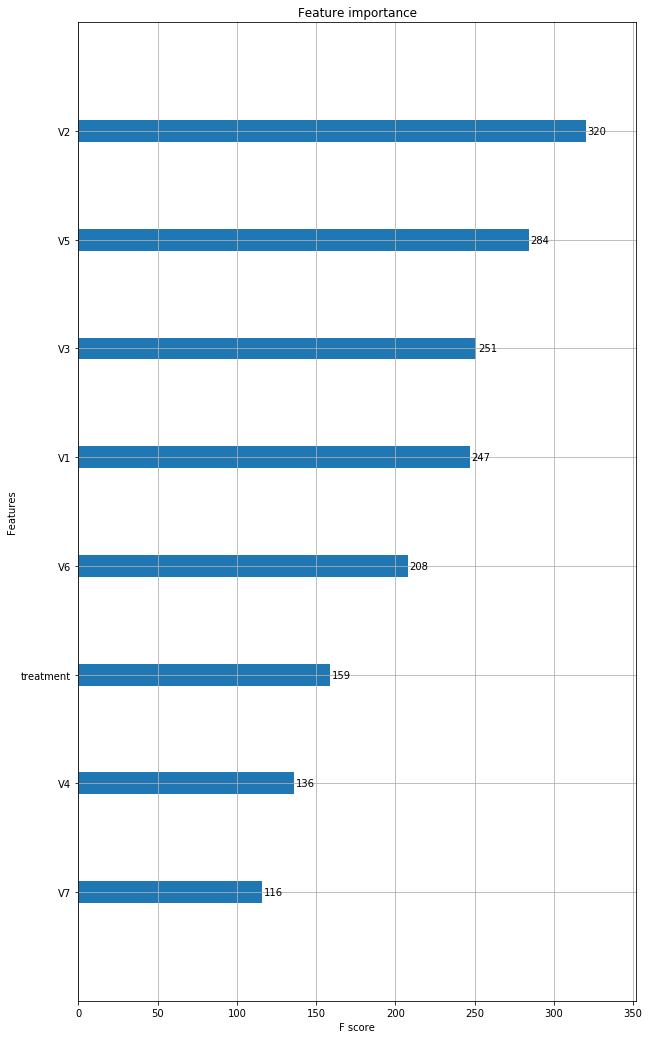

In [19]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

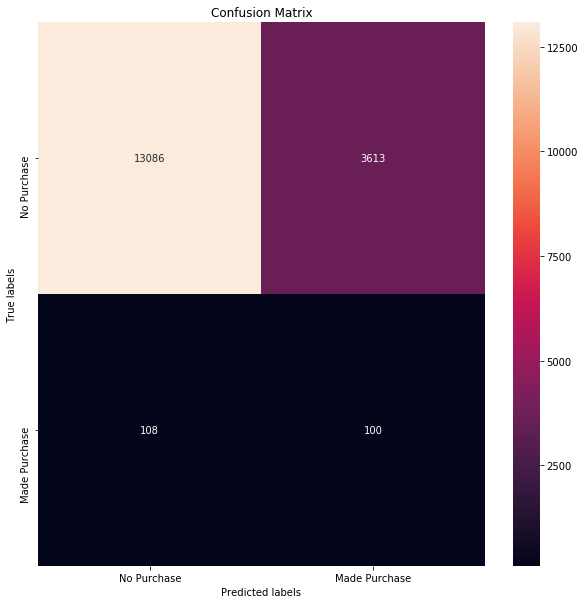

In [75]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [76]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    
    for prob in lift:
        if prob > 0:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [77]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Nice job!  See how well your strategy worked on our valid data below!

Your irr with this strategy is 0.0105.

Your nir with this strategy is -324.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.010537153736024804, -324.5999999999999)

# model records

In [78]:
# final= pd.DataFrame()

details = 'Fine tuning XGBOOST by Medium'
irr_results = 0.0105
nir_results = -324.5999

In= pd.DataFrame({'details':details,
             'irr_results': irr_results,
             'nir_results': nir_results}, index=[0])

final= final.append(In)
final

,details,irr_results,nir_results
0,regular github approach,0.0141,-47.3990
0,Didn't use SMOTE (The result was the same!!),0.0141,-47.3990
0,Fine tuning XGBOOST by Medium,0.0105,-324.5999


# Final Test Results

In [23]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0154.

Your nir with this strategy is 42.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yogi.cahyono/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.015416668070903982, 42.59999999999991)